<a href="https://colab.research.google.com/github/Location-Artistry/GEO-DEV-NOTEBOOKS/blob/main/REPORT_WORKFLOW.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Full test of inserting figures into Doc Template**

## Imports & Functions

In [1]:
# Colab libraries install & mount google drive to access credentials
#!pip install google-api-python-client google-auth-httplib2 google-auth-oauthlib 
import os
from __future__ import print_function
import os.path
from googleapiclient.discovery import build
from google_auth_oauthlib.flow import InstalledAppFlow
from google.auth.transport.requests import Request
from google.oauth2.credentials import Credentials
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [27]:
# Get and return GoogleAPIS credentials
def getGcreds(CLIENT_SECRETS_FILE, SCOPES):
  flow = InstalledAppFlow.from_client_secrets_file(CLIENT_SECRETS_FILE, SCOPES)
  credentials = flow.run_console()
  return credentials

# Create copy of Gdoc from template
def copyFile(DOCUMENT_ID, copyTitle, credentials):
  API_SERVICE_NAME = 'drive'
  API_VERSION = 'v3'
  service = build(API_SERVICE_NAME, API_VERSION, credentials = credentials)
  newText = {'name': copyTitle}
  try:
    result = service.files().copy(fileId=DOCUMENT_ID, body=newText).execute()
    display(result)
    return result['id']
  except (errors.HttpError, error):
    print('An error occurred: %s') % error
  return None

# List files in drive, pass number desired file results
def listFiles(num, credentials):
  API_SERVICE_NAME = 'drive'
  API_VERSION = 'v3'
  service = build(API_SERVICE_NAME, API_VERSION, credentials = credentials)
  results = service.files().list(
        pageSize=num, fields="nextPageToken, files(id, name, mimeType, size, parents, modifiedTime)").execute()
  items = results['files']
  # list all 20 files & folders
  for x, i in enumerate(items):
    display(f'{x} - {i.get("id")} - {i.get("mimeType")} - {i.get("parents")} - {i.get("modifiedTime")}')
  #for item in items:
  #  display(item)
  return items

  # Drive search function, template from Google Developers
def fileSearch(type,query,credentials):
  f = {'jpeg': "mimeType='image/jpeg'",'pdf':"mimeType='application/pdf'",'doc':"mimeType='application/vnd.google-apps.document'",
     'sheet':"mimeType='application/vnd.google-apps.spreadsheet'",'folder':"mimeType='application/vnd.google-apps.folder'",'png':"mimeType='image/png'",
     'text':"mimeType='text/plain'"}
  API_SERVICE_NAME, API_VERSION, page_token = 'drive','v3',None
  drive_service = build(API_SERVICE_NAME, API_VERSION, credentials = credentials)
  query = (f"{f[type]}{query}")
  while True:
    response = drive_service.files().list(q=query,spaces='drive',fields='nextPageToken, files(id, name)',pageToken=page_token).execute()
    for x, file in enumerate(response.get('files', [])):
      display(f'Found {x}: {file.get("name")} - {file.get("id")}')
    page_token = response.get('nextPageToken', None)
    if page_token is None:
      break
  return response['files']
  
# Update document with spcified requests
def updateDoc(DOCUMENT_ID, req, credentials):
  API_SERVICE_NAME = 'docs'
  API_VERSION = 'v1'
  service = build(API_SERVICE_NAME, API_VERSION, credentials = credentials)
  result = service.documents().batchUpdate(documentId=DOCUMENT_ID, body={'requests': req}).execute()
  display(f'Edit Successful for id: {result["documentId"]} Changes made: {result["replies"][0]}')
  return result

## Install Plotly Express and associated libraries

In [ ]:
!pip install -U plotly
import plotly
print(plotly.__version__)
from urllib.request import urlopen
import json
import pandas as pd
import plotly.express as px

# orca to export plotly images
!wget https://github.com/plotly/orca/releases/download/v1.2.1/orca-1.2.1-x86_64.AppImage -O /usr/local/bin/orca
!chmod +x /usr/local/bin/orca
!apt-get install xvfb libgtk2.0-0 libgconf-2-4

In [ ]:
with urlopen('https://raw.githubusercontent.com/plotly/datasets/master/geojson-counties-fips.json') as response:
    counties = json.load(response)
counties["features"][0]

In [ ]:
import pandas as pd
df = pd.read_csv("https://raw.githubusercontent.com/plotly/datasets/master/fips-unemp-16.csv",
                   dtype={"fips": str})
df.head()

In [79]:
import plotly.express as px
fig = px.choropleth(df, geojson=counties, locations='fips', color='unemp',
                           color_continuous_scale="Viridis",
                           range_color=(0, 12),
                           scope="usa",
                           labels={'unemp':'unemployment rate'}
                          )
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
#fig.show()
fig.write_image("fig1.png")

In [92]:
# loop through list of figure names, name files dynamically
names = ['fig11','fig21','fig31']
for name in names:
  fig = px.choropleth(df, geojson=counties, locations='fips', color='unemp',color_continuous_scale="Viridis",range_color=(0, 12),scope="usa",labels={'unemp':'unemployment rate'})
  fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
  fig.write_image(f'{name}.png')

In [93]:
# loop throug list of figures and insert dynamically by name
for name in names:
  s = (f'and name contains "{name}"')
  search = fileSearch('png', s, credentials)
  params = [{'insertInlineImage': {'location': {'index': 1},'uri':(f'http://drive.google.com/uc?export=view&id={search[0]["id"]}'),
        'objectSize': {'height': {'magnitude': 50,'unit': 'PT'},'width': {'magnitude': 50,'unit': 'PT'}}}}]
  docResult = updateDoc(copyID, params, credentials)

'Found 0: fig11.png - 1-WcF3szSRVgBTMsJJZxyOBd7StvBM3Nc'

"Edit Successful for id: 1fFBXoHE1zNdyPRPd_Y6ITkhIvDo7YYChHJxD8E1QM3U Changes made: {'insertInlineImage': {'objectId': 'kix.oms2sptr7508'}}"

'Found 0: fig21.png - 1-bQqLRQOfKofaJuJV3UKqZLIrrxN5CyW'

"Edit Successful for id: 1fFBXoHE1zNdyPRPd_Y6ITkhIvDo7YYChHJxD8E1QM3U Changes made: {'insertInlineImage': {'objectId': 'kix.tyukelhe4jgn'}}"

'Found 0: fig31.png - 1-euPGwhJFb9DOmTaxkYIJ-CH3PLFnIcT'

"Edit Successful for id: 1fFBXoHE1zNdyPRPd_Y6ITkhIvDo7YYChHJxD8E1QM3U Changes made: {'insertInlineImage': {'objectId': 'kix.223fxsbvecrw'}}"

In [80]:
# Workflow for indivvidual images
# find recently created image export
s = "and name contains 'fig1'"
#s = "id contains '1uBK5Sgzjuy7pNdKQ-ANf8pskXdM6K8libKfkpZ1z1lo'"
search = fileSearch('png', s, credentials)

'Found 0: fig1.png - 1-N-gWS5mmC-jLrnUsRkkdzvjhnB0Nn-T'

In [81]:
# insert chart into specified location in document
params = [{'insertInlineImage': {'location': {'index': 1},'uri':(f'http://drive.google.com/uc?export=view&id={search[0]["id"]}'),
        'objectSize': {'height': {'magnitude': 50,'unit': 'PT'},'width': {'magnitude': 50,'unit': 'PT'}}}}]
docResult = updateDoc(copyID, params, credentials)

"Edit Successful for id: 1fFBXoHE1zNdyPRPd_Y6ITkhIvDo7YYChHJxD8E1QM3U Changes made: {'insertInlineImage': {'objectId': 'kix.ssluskf13hc6'}}"

## Plotly styled DataFrame Export

In [ ]:
import plotly.graph_objects as go

fig = go.Figure(data=[go.Table(header=dict(values=['A Scores', 'B Scores']),
                 cells=dict(values=[[100, 90, 80, 90], [95, 85, 75, 95]]))
                     ])
fig.show()

In [ ]:
import plotly.graph_objects as go

fig = go.Figure(data=[go.Table(
    header=dict(values=['A Scores', 'B Scores'],
                line_color='darkslategray',
                fill_color='lightskyblue',
                align='left'),
    cells=dict(values=[[100, 90, 80, 90], # 1st column
                       [95, 85, 75, 95]], # 2nd column
               line_color='darkslategray',
               fill_color='lightcyan',
               align='left'))
])

fig.update_layout(width=500, height=300)
fig.show()

In [ ]:
import plotly.graph_objects as go
import pandas as pd

df = pd.read_csv('https://raw.githubusercontent.com/plotly/datasets/master/2014_usa_states.csv')

fig = go.Figure(data=[go.Table(
    header=dict(values=list(df.columns),
                fill_color='paleturquoise',
                align='left'),
    cells=dict(values=[df.Rank, df.State, df.Postal, df.Population],
               fill_color='lavender',
               align='left'))
])

name = 'df1'
fig.show()
fig.write_image(f'{name}.png')

## Seaborn Plots Export image

In [17]:
import matplotlib.pyplot as plt
plt.style.use('classic')
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
sns.set()

In [30]:
# set directory to save image exports
os.chdir('/content/drive/MyDrive/TEST-PROD')
#os.getcwd()

In [18]:
# Create some data
rng = np.random.RandomState(0)
x = np.linspace(0, 10, 500)
y = np.cumsum(rng.randn(500, 6), 0)

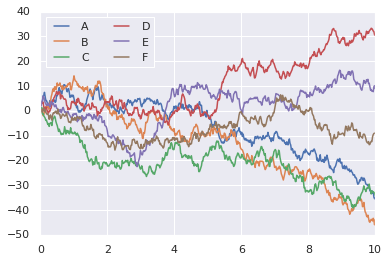

In [41]:
# Create and save high quality plot
plt.plot(x, y)
plt.legend('ABCDEF', ncol=2, loc='upper left')
plt.savefig('PLOT1.png', dpi=300)

In [31]:
 # Verify and create credentials
CLIENT_SECRETS_FILE = "CRED-DESK.json"
SCOPES = ['https://www.googleapis.com/auth/drive', 'https://www.googleapis.com/auth/documents', 'https://www.googleapis.com/auth/spreadsheets']
# verify credentials run once when initalizing workflow
credentials = getGcreds(CLIENT_SECRETS_FILE,SCOPES)

Please visit this URL to authorize this application: https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=244871284916-ieooau3uf8ilc792obrsk33nu933918c.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocuments+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fspreadsheets&state=POvLLJMrYLmAra9pGMJ1iVfmObjlJS&prompt=consent&access_type=offline
Enter the authorization code: 4/1AY0e-g4ENOzYNWhGHY3T0LfbBVTwXK2H4ejoC_NO9IhVyBA2Am6fcHKsB-w


In [33]:
# Create new WQAR from Template
DOCUMENT_ID = '1XSZRy7p0e75NoxFd_J5JyvCDpRGRwWixYc6BadGHLq8'
docTitle = 'WQAR 2024 DRAFT'
copyID = copyFile(DOCUMENT_ID, docTitle, credentials)

{'id': '1fFBXoHE1zNdyPRPd_Y6ITkhIvDo7YYChHJxD8E1QM3U',
 'kind': 'drive#file',
 'mimeType': 'application/vnd.google-apps.document',
 'name': 'WQAR 2024 DRAFT'}

In [53]:
# find recently created image export
s = "and name contains 'PLOT1'"
#s = "id contains '1uBK5Sgzjuy7pNdKQ-ANf8pskXdM6K8libKfkpZ1z1lo'"
search = fileSearch('png', s, credentials)

'Found 0: PLOT1.png - 1-ElC6io7y5LbnoX_rFBSOqiePMu3nXEG'

In [54]:
# insert chart into specified location in document
params = [{'insertInlineImage': {'location': {'index': 1},'uri':(f'http://drive.google.com/uc?export=view&id={search[0]["id"]}'),
        'objectSize': {'height': {'magnitude': 50,'unit': 'PT'},'width': {'magnitude': 50,'unit': 'PT'}}}}]
docResult = updateDoc(copyID, params, credentials)

"Edit Successful for id: 1fFBXoHE1zNdyPRPd_Y6ITkhIvDo7YYChHJxD8E1QM3U Changes made: {'insertInlineImage': {'objectId': 'kix.l6vj7jyx5oht'}}"

## Pandas-Bokeh - Hold off for now

In [ ]:
# pandas_bokeh Section
# Important library for many geopython libraries
!apt install gdal-bin python-gdal python3-gdal 
# Install rtree - Geopandas requirment
!apt install python3-rtree 
# Install Geopandas
!pip install git+git://github.com/geopandas/geopandas.git
# Install descartes - Geopandas requirment
!pip install descartes 
!pip install pandas-bokeh

import requests
import geopandas as gpd
import pandas as pd
import pandas_bokeh
pandas_bokeh.output_notebook()


In [ ]:
#Download GeoJSON example data:
geojson = 'https://raw.githubusercontent.com/PublicaMundi/MappingAPI/master/data/geojson/us-states.json'    
#Read in GeoJSON:
gdf = gpd.read_file(geojson)
gdf.head()

In [15]:
gdf.plot_bokeh(simplify_shapes=10000)

Figure(id='1299', ...)

In [14]:
pandas_bokeh.output_file("Interactive Plot.jpg")